In [ ]:
# Install Python 3.10 and required tools
!apt-get update -y
!apt-get install python3.10 python3.10-distutils -y

# Set Python 3.10 as default
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!update-alternatives --set python3 /usr/bin/python3.10

# Reinstall pip and upgrade it
!apt-get install python3-pip -y
!python3 -m pip install --upgrade pip

# Reinstall core libraries
!pip install numpy pandas cupy-cuda11x cuml-cu11 --extra-index-url=https://pypi.nvidia.com


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,984 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,021 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,765 kB]
Get:13 http://archive.ubuntu.com/ubunt

### Sentence Embeddings

In [ ]:
import ast
import re
def process_inverted_index_string(inverted_index_str):
    try:
        inverted_index = ast.literal_eval(inverted_index_str)
        position_word_pairs = []
        for word, positions in inverted_index.items():
            for pos in positions:
                position_word_pairs.append((pos, word))
        position_word_pairs.sort()
        words = [word for _, word in position_word_pairs]
        text = ' '.join(words)
        text = re.sub(r'\s([?.!,;:])', r'\1', text)
        return text
    except:
        return ""

In [ ]:
import dask.dataframe as dd
df = dd.read_parquet('checkpoint_datacleaning2')
df.head()

,abstract_inverted_index,apc_list,apc_paid,authors_count,cited_by_api_url,cited_by_count,cited_by_percentile_year,concepts_count,corresponding_author_ids,corresponding_institution_ids,...,type_id,updated,updated_date,versions,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging
0,None,None,None,0,https://api.openalex.org/works?filter=cites:W4...,0,"{'min': 0, 'max': 66}",6,[],[],...,https://openalex.org/work-types/article,2025-01-17T01:18:43.637758,2025-01-17T01:18:43.637758,[],<NA>,<NA>,<NA>,NaN,True,NaN
1,None,None,None,1,https://api.openalex.org/works?filter=cites:W2...,0,"{'min': 0, 'max': 63}",7,['https://openalex.org/A5101726172'],['https://openalex.org/I4210135744'],...,https://openalex.org/work-types/article,2025-01-17T11:40:31.631339,2025-01-17T11:40:31.631339,[],Diet and metabolism studies,Medicine,Health Sciences,0.9972,True,NaN
2,None,None,None,1,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",7,['https://openalex.org/A5016168871'],[],...,https://openalex.org/work-types/article,2025-01-17T17:49:01.433374,2025-01-17T17:49:01.433374,[],Pharmacogenetics and Drug Metabolism,"Pharmacology, Toxicology and Pharmaceutics",Life Sciences,0.9786,True,NaN
3,None,None,None,2,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",5,[],[],...,https://openalex.org/work-types/article,2025-01-17T09:04:08.282477,2025-01-17T09:04:08.282477,[],Traditional Chinese Medicine Studies,Medicine,Health Sciences,0.9960,True,NaN
4,None,None,None,3,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",11,[],[],...,https://openalex.org/work-types/article,2025-01-17T14:44:13.147750,2025-01-17T14:44:13.147750,[],Autophagy in Disease and Therapy,Medicine,Health Sciences,0.9991,True,NaN


In [ ]:
"""
df_non_aging = df[df["is_aging"] == 1][["id", "abstract_inverted_index","title"]].copy()

df_non_aging["abstract_clean"] = df_non_aging["abstract_inverted_index"].map(
    process_inverted_index_string,
    meta=('abstract_clean', 'str')
)

# Keep only cleaned text
df_cleaned = df_non_aging[["id","abstract_clean","title"]]
df_cleaned.to_parquet("non_aging_cleaned_abstracts.parquet", write_index=False)
"""

In [ ]:
!pip install langdetect --upgrade --no-cache-dir
import dask.dataframe as dd
from langdetect import detect
from tqdm import tqdm
import pandas as pd

# Load data
df_clean = dd.read_parquet('non_aging_cleaned_abstracts.parquet')
df_clean = df_clean.dropna().compute()

# ---------------------------------------------------
# Junk indicators
OBITUARY_JUNK_INDICATORS = [
    "was born in", "grew up in", "he was proud of", "she was proud of", "proud of",
    "attended school", "attended university", "attended grammar school", "his wife of", "her husband of",
    "he enjoyed", "she enjoyed", "loved to", "she leaves", "predeceased by",
    "obituary", "in memory of", "tribute to", "loving memory", "former general practitioner",
    "memorial service", "burial", "eulogy",
    "rotary club", "scouting", "good companions", "bedminster local history",
    "dunkirk veterans", "lifelong learning", "bishop of", "parish priest", "church warden",
    "served as priest", "was ordained", "assistant priest", "honorary curate",
    "lord mayor", "queen’s birthday honours", "medal for outstanding service", "MBE", "territorial decoration",
    "the journal is pleased to announce", "this issue commemorates", "impact factor",
    "download citation", "refworks", "zotero", "citation manager", "resumes en français"
]

RESEARCH_KEYWORDS = [
    "objective", "methods", "results", "conclusion", "background",
    "we conducted", "this study", "our findings", "patients", "retrospective",
    "clinical trial", "case report", "systematic review"
]

# ---------------------------------------------------
# Filtering functions
def is_obvious_junk(text):
    text_lower = text.lower()
    return any(k in text_lower for k in OBITUARY_JUNK_INDICATORS)

def is_probably_not_research(text):
    if len(text.strip().split()) < 30:
        return True
    text_lower = text.lower()
    return not any(k in text_lower for k in RESEARCH_KEYWORDS)

def is_not_english(text):
    try:
        return detect(text) != "en"
    except:
        return True

# ---------------------------------------------------
# Apply filtering on dataframe
tqdm.pandas(desc="Filtering")
df_clean["is_junk"] = df_clean["abstract_clean"].progress_apply(is_obvious_junk)
df_clean["not_research"] = df_clean["abstract_clean"].progress_apply(is_probably_not_research)
df_clean["not_english"] = df_clean["abstract_clean"].progress_apply(is_not_english)

# Keep only clean entries
df_filtered = df_clean.loc[
    (~df_clean["is_junk"]) &
    (~df_clean["not_research"]) &
    (~df_clean["not_english"])
]

# Drop duplicate abstracts
df_filtered = df_filtered.drop_duplicates(subset="abstract_clean")

# Convert to lists
texts = df_filtered["abstract_clean"].tolist()
ids = df_filtered["id"].tolist()

# ---------------------------------------------------
# Summary
print(f"Original abstracts: {len(df_clean)}")
print(f"Filtered & deduplicated abstracts: {len(df_filtered)}")
print(f"Removed total: {len(df_clean) - len(df_filtered)}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=0baf26d1736f17c7e33ff2586963b902c34a98650a7f79cf3d0fd9358406df09
  Stored in directory: /tmp/pip-ephem-wheel-cache-92vj7y6m/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


Filtering: 100%|██████████| 1531574/1531574 [2:11:28<00:00, 194.15it/s]


Original abstracts: 1531574
Filtered & deduplicated abstracts: 1117162
Removed total: 414412


In [2]:
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('malteos/scincl')  # biomedical + inference tasks
embeddings = model.encode(texts, batch_size=512, show_progress_bar=True)

# Compute the (cosine) similarity between embeddings
similarity = model.similarity(embeddings[0], embeddings[1])
print(similarity.item())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Batches:   0%|          | 0/2182 [00:00<?, ?it/s]

0.6778609752655029


In [ ]:
import numpy as np

np.save('embeddings_scincl.npy', embeddings)
np.save('ids_scincl.npy', ids)

In [4]:
print("fuck")

fuck


In [ ]:
import shutil
shutil.move("non_aging_cleaned_abstracts.parquet", "non_aging_cleaned_abstracts.parquet")

### Dimensionality Reduction

In [ ]:
import numpy as np

embeddings = np.load('embeddings_scincl.npy')
ids = np.load('ids_scincl.npy')


In [ ]:
import dask.dataframe as dd
df_clean = dd.read_parquet('non_aging_cleaned_abstracts.parquet')
df_clean = df_clean.dropna().compute()

texts = (df_clean["abstract_clean"]).tolist()

In [3]:
len(embeddings)

1117162

In [ ]:
len(texts)

1531574

In [4]:
from cuml import UMAP
# Imports
import numpy as np
import cupy as cp

X_gpu = cp.asarray(embeddings)

# UMAP (GPU)
umap_model = UMAP(n_neighbors=30, n_components=200, metric='cosine')
embeddings_umap = umap_model.fit_transform(X_gpu)


[2025-06-08 04:13:29.366] [CUML] [info] Building knn graph using nn descent


In [5]:
import cupy as cp
# Convert your UMAP embeddings to GPU if needed
gpu_data = cp.asarray(embeddings_umap)

In [6]:
import cuml
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

k_values = list(range(50,1000,25))
silhouette_scores = []
calinski_scores = []
davies_scores = []

sample_size = 25000

def gini(array):
    sorted_array = np.sort(array)
    n = len(array)
    cumvals = np.cumsum(sorted_array)
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n

for k in k_values:
    print(f"Processing k={k}...")

    # Fit KMeans on GPU
    kmeans = cuKMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(gpu_data)
    labels = kmeans.labels_.get()  # Get labels to CPU

    # Random sample for silhouette score
    idx = cp.random.choice(gpu_data.shape[0], sample_size, replace=False)
    sample_data = cp.asnumpy(gpu_data[idx])
    sample_labels = labels[idx.get()]

    # Silhouette (slow)
    try:
        silhouette = silhouette_score(sample_data, sample_labels)
    except ValueError as e:
        print(f"Silhouette error at k={k}: {e}")
        silhouette = np.nan  # Or any sentinel value you'd prefer

    silhouette_scores.append(silhouette)

    # Full data for fast metrics
    full_data_cpu = cp.asnumpy(gpu_data)
    calinski = calinski_harabasz_score(full_data_cpu, labels)
    davies = davies_bouldin_score(full_data_cpu, labels)

    calinski_scores.append(calinski)
    davies_scores.append(davies)

    print(f"k={k} | Silhouette: {silhouette:.4f} | CH: {calinski:.2f} | DB: {davies:.4f}")

    labels = kmeans.labels_.get()  # Get labels to CPU

    # Print label distribution
    _, counts = np.unique(labels, return_counts=True)
    gini_index = gini(counts)
    print(f"Gini coefficient: {gini_index:.4f}")


Processing k=50...
k=50 | Silhouette: 0.9356 | CH: 2519.54 | DB: 0.0201
Gini coefficient: 0.9800
Processing k=75...
k=75 | Silhouette: 0.9763 | CH: 2287.10 | DB: 0.0217
Gini coefficient: 0.9866
Processing k=100...
k=100 | Silhouette: 0.2467 | CH: 5628.76 | DB: 0.0522
Gini coefficient: 0.9800
Processing k=125...
k=125 | Silhouette: 0.2443 | CH: 4845.07 | DB: 0.7181
Gini coefficient: 0.9840
Processing k=150...
k=150 | Silhouette: 0.3077 | CH: 7343.00 | DB: 0.0447
Gini coefficient: 0.9839
Processing k=175...
k=175 | Silhouette: 0.3006 | CH: 8780.57 | DB: 0.5543
Gini coefficient: 0.9793
Processing k=200...
k=200 | Silhouette: 0.3027 | CH: 8041.43 | DB: 0.4697
Gini coefficient: 0.9818
Processing k=225...
k=225 | Silhouette: 0.3023 | CH: 7439.00 | DB: 0.0437
Gini coefficient: 0.9838
Processing k=250...
k=250 | Silhouette: 0.2985 | CH: 6938.83 | DB: 0.5393
Gini coefficient: 0.9854
Processing k=275...
k=275 | Silhouette: 0.3148 | CH: 7475.74 | DB: 0.0428
Gini coefficient: 0.9853
Processing k=3

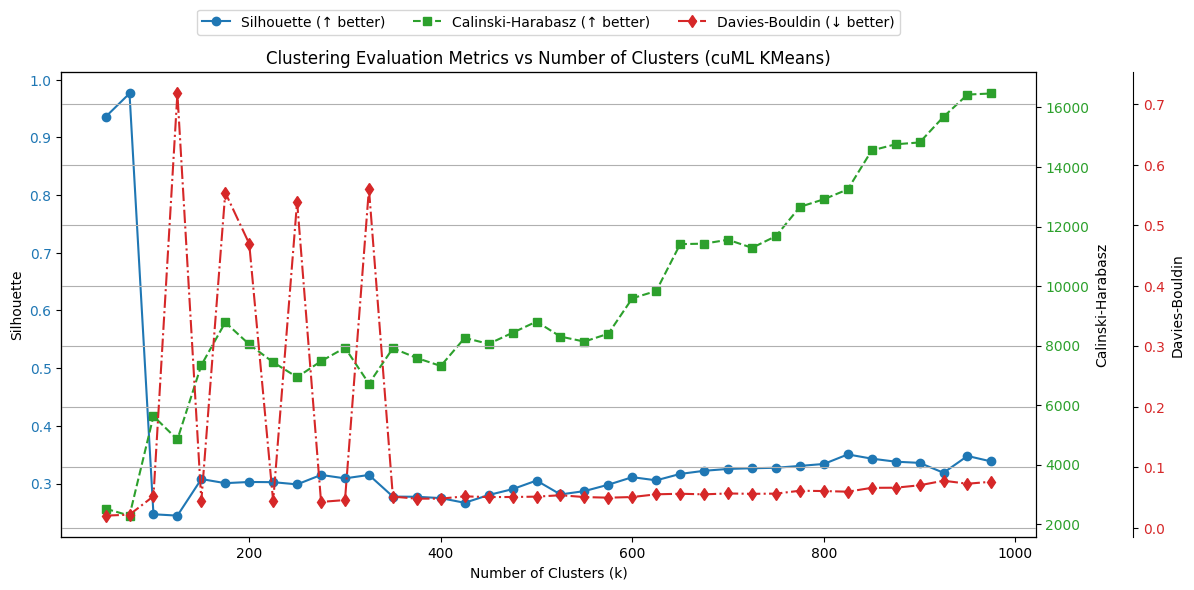

In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Silhouette axis (left)
color1 = 'tab:blue'
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Silhouette")
l1, = ax1.plot(k_values, silhouette_scores, 'o-', color=color1, label="Silhouette (↑ better)")
ax1.tick_params(axis='y', labelcolor=color1)

# Calinski-Harabasz axis (right)
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel("Calinski-Harabasz")
l2, = ax2.plot(k_values, calinski_scores, 's--', color=color2, label="Calinski-Harabasz (↑ better)")
ax2.tick_params(axis='y', labelcolor=color2)

# Davies-Bouldin axis (right offset)
ax3 = ax1.twinx()
color3 = 'tab:red'
ax3.spines['right'].set_position(("axes", 1.1))
ax3.set_ylabel("Davies-Bouldin")
l3, = ax3.plot(k_values, davies_scores, 'd-.', color=color3, label="Davies-Bouldin (↓ better)")
ax3.tick_params(axis='y', labelcolor=color3)

# Unified legend
lines = [l1, l2, l3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# Titles and layout
plt.title("Clustering Evaluation Metrics vs Number of Clusters (cuML KMeans)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

# Step 1: Fit KMeans on full embeddings
gpu_data = cp.asarray(embeddings_umap)
kmeans = cuKMeans(n_clusters=825, random_state=42, n_init=10)  # suppress future warning
kmeans.fit(gpu_data)
cluster_labels = kmeans.labels_.get()



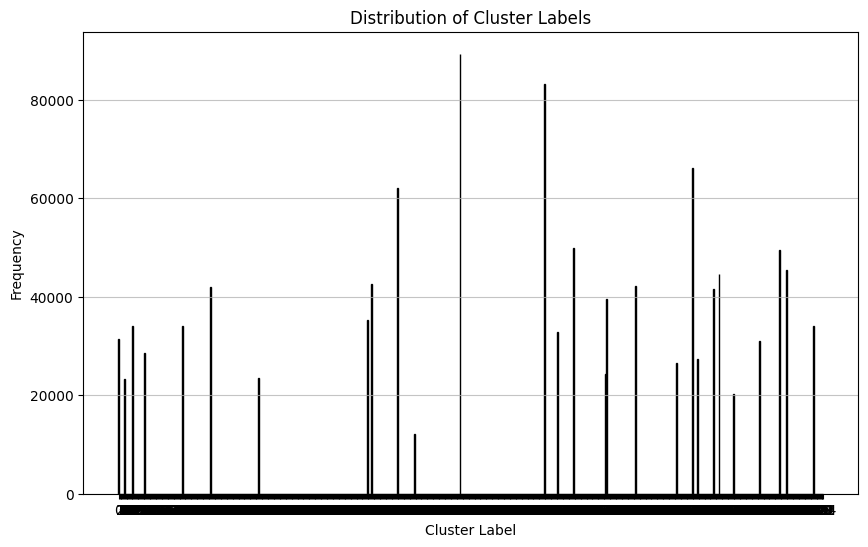

In [10]:
# prompt: plot the distribution of cluster_labels

# Step 2: Plot the distribution of cluster_labels
plt.figure(figsize=(10, 6))
plt.hist(cluster_labels, bins=np.arange(cluster_labels.min(), cluster_labels.max() + 1) - 0.5, edgecolor='black')
plt.title('Distribution of Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.xticks(np.arange(cluster_labels.min(), cluster_labels.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()


In [13]:
# prompt: provide 5 corresponding text for top 10 clusters

# Step 3: Get the top 10 most frequent clusters
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
# Combine labels and counts into pairs and sort by count in descending order
label_counts = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
# Get the labels of the top 10 clusters
top_10_cluster_labels = [label for label, count in label_counts[:10]]

# Step 4: Create a DataFrame to easily access original texts
# Make sure the DataFrame `df_clean` contains the original texts and the corresponding IDs
# And ensure `cluster_labels` are aligned with the order of texts/IDs in `df_clean`
df_filtered = df_clean[df_clean['id'].isin(ids)].copy()
df_filtered['cluster'] = cluster_labels

# Step 5: Print 5 example texts for each of the top 10 clusters
for cluster_label in top_10_cluster_labels:
    print(f"\n--- Examples for Cluster {cluster_label} ---")
    # Get texts belonging to the current cluster
    cluster_texts = df_filtered[df_filtered['cluster'] == cluster_label]['abstract_clean'].tolist()
    # Print up to 5 examples from this cluster
    for i, text in enumerate(cluster_texts[:5]):
        print(f"Example {i+1}: {text[:500]}...") # Print first 500 characters


--- Examples for Cluster 399 ---
Example 1: &lt;b&gt;&lt;i&gt;Background:&lt;/i&gt;&lt;/b&gt; Information regarding morbidity and mortality of infants born with end-stage renal disease (ESRD) requiring dialysis early in life is critical to optimize patient care and better counsel families. &lt;b&gt;&lt;i&gt;Objective:&lt;/i&gt;&lt;/b&gt; We evaluated outcomes of infants born regionally with ESRD, and those within our broader catchment area referred for dialysis. &lt;b&gt;&lt;i&gt;Study Design:&lt;/i&gt;&lt;/b&gt; We screened deaths at 5 r...
Example 2: Energy drinks (EDs) are commonly consumed by youth. They are often used as a source of energy in order to enhance physical and mental performance. Case reports, observational studies, and meta-analyses have been reported in order to determine the effects of EDs on cardiovascular changes. The detrimental effects of EDs are cardiac arrhythmias, myocardial infarction, prolonged QT interval, aortic dissection, and death. A case with proxima

In [14]:
# Step 2: Create a DataFrame with ids and cluster labels
cluster_df = pd.DataFrame({
    "id": ids,
    "cluster": cluster_labels
})

# Step 3: Merge with df_clean on 'id'
import dask.dataframe as dd
df_clean = df_filtered.copy()
df_clustered = df_clean.merge(cluster_df, how="left", on="id")

In [15]:
df_clustered.to_parquet("df_clustered.parquet", index=False)

In [ ]:
import shutil
shutil.move("df_clustered.parquet", "df_clustered.parquet")

In [18]:
df_clustered.head()

,id,abstract_clean,cluster_x,cluster_y
0,https://openalex.org/W3048280953,The notion that the immune system can be manip...,498,498
1,https://openalex.org/W2370857924,LIM domain-binding protein 1 (Ldb1) is a nucle...,0,0
2,https://openalex.org/W2166587078,Patients undergoing arthroplasty surgery are r...,326,326
3,https://openalex.org/W3029081899,"Objective To explore the clinical features, p...",604,604
4,https://openalex.org/W2887453391,"In March 2017, waiting times for an outpatient...",326,326


In [19]:
df_clustered = df_clustered.rename(columns={'cluster_x': 'cluster'})
df_clustered = df_clustered.drop('cluster_y', axis=1)